In [134]:
import numpy as np
from scipy import stats
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt

# Lab 2

## Problem 1

We assume that the average background is 3 events per day and that our candidate source produces 8 events per day.

### (A)

Below, we plot the distribution after integrating over 1, 2, 5 and 10 days. Both the mean and variance grow as the number of days increases.

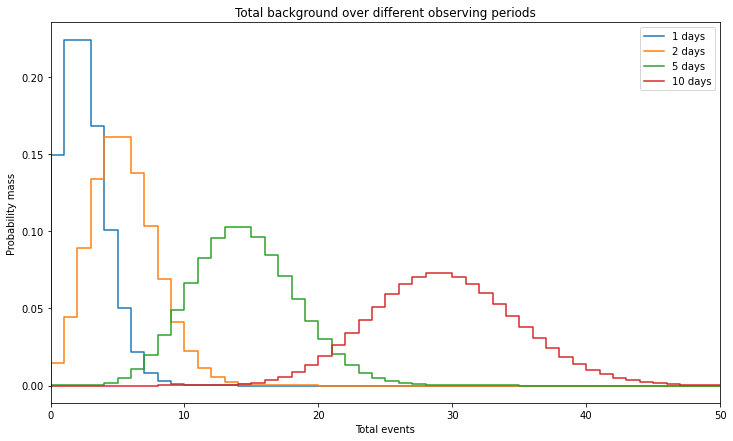

In [135]:
mu = 3
xmax = 50

# single day background distribution
x = np.arange(0, xmax + 1)
pmf = stats.poisson.pmf(x, mu=mu)

# container lists for the convolved distributions
sum_xs = []
conv_pmfs = []

ns = [1,2,5,10] # number of days to integrate over
for n in ns:
    sum_x = np.arange(0, n * xmax + 1)
    conv_pmf = pmf
    # convolve n - 1 times
    for _ in range(0,n-1):
        conv_pmf = signal.convolve(conv_pmf, pmf)
    sum_xs.append(sum_x)
    conv_pmfs.append(conv_pmf)
    
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.set_xlim([0,50])
    
for n, sum_x, conv_pmf in zip(ns, sum_xs, conv_pmfs):
    ax.step(sum_x, conv_pmf, label=f"{n} days")
    
ax.set_title("Total background over different observing periods")
ax.set_xlabel("Total events")
ax.set_ylabel("Probability mass")
ax.legend();

### (B)

The Poisson distribution describes the number of events expected to occur in a given time period assuming the events are independent. Since the events are independent, integrating over a longer time period should simply give a Poisson distribution with a larger mean. Indeed, below we have plotted the 5-day distribution (bottom left plot above) against a Poisson distribution with a mean 5-times larger than the single-day mean and can see that they agree.

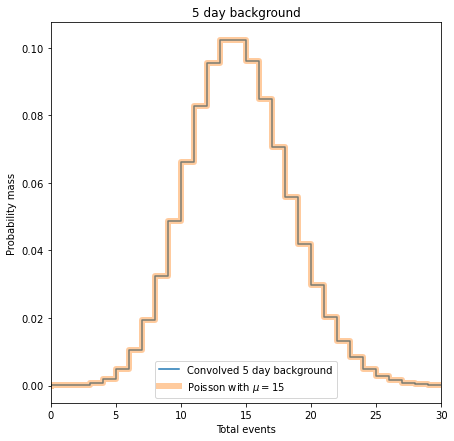

In [139]:
x = sum_xs[2]
pmf = conv_pmfs[2]

fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.step(x, pmf, label="Convolved 5 day background")
ax.step(x, stats.poisson.pmf(x, mu=mu*5), linewidth=6, alpha=0.4, label="Poisson with $\mu = 15$") 
ax.set_xlim([0,30]);
ax.set_title("5 day background")
ax.set_xlabel("Total events")
ax.set_ylabel("Probability mass")
ax.legend()

### (C)

To averaged distribution is simply the summed distribution with the x-axis rescaled according to the number of samples (days) over which the average is taken. As the number of days increases, the distribution becomes narrower and more symmetric while the mean remains the same. In particular, the 10 day average is starting to look somewhat Gaussian, as we would expect from the central limit theorem. However, we know from part (B) that the convolution of Poisson distributions is still a Poisson distribution, so the average should always just be a rescaled Poisson distribution. This seems at first to contradict the CLT, but it does not because the Poisson distribution approaches a Gaussian for large values of $\mu$.

(The fact that the height of the graph decreases as the number of days increases is just a consequence of the decreasing bin size.)

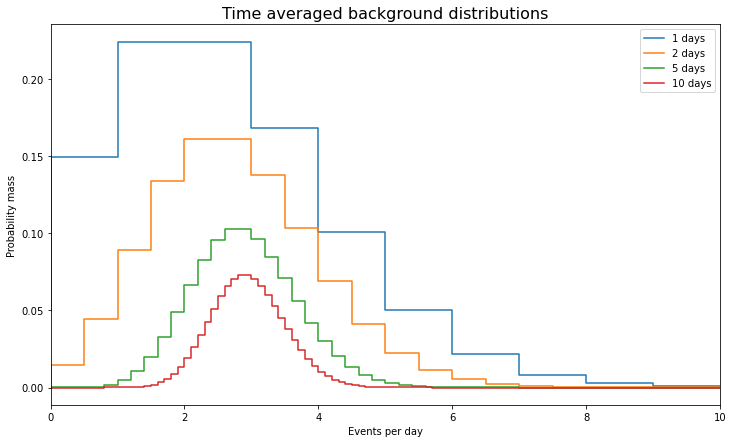

In [123]:
avg_xs = [x / n for x,n in zip(sum_xs, ns)]

fig, ax = plt.subplots(1,1, figsize=(12,7))

for n, avg_x, conv_pmf in zip(ns, avg_xs, conv_pmfs):
    ax.step(avg_x, conv_pmf, label=f"{n} days")
    
ax.set_xlim([0,10])
ax.set_title("Time averaged background distributions", fontsize=16)
ax.set_xlabel("Events per day")
ax.set_ylabel("Probability mass")
ax.legend();

### (D)

Below we tabulate the statistical significance of seeing 8 events per day for $N$ days, assuming the same background as above, for various values of $N$. 

(Rather than using the pdfs calculated above via convolution, we use the result of part (B) that the background distribution for an $N$ day observing run is just a Poisson with mean $N\mu$.)

In [41]:
for n in ns:
    observed = n * 8
    prob = stats.poisson.sf(observed, mu=mu*n)
    sigma = stats.norm.isf(prob)
    print(f"{n} days: \t {prob:.3} \t {sigma:.3} sigma")

1 days: 	 0.0038 	 2.67 sigma
2 days: 	 0.000175 	 3.58 sigma
5 days: 	 2.34e-08 	 5.46 sigma
10 days: 	 1.12e-14 	 7.64 sigma


## Problem 2

Suppose our background over a single day of observing is described by a Rayleigh distribution with scale 5.5.

### (A)

Below we plot the background distributions expected after averaging over various observing intervals.

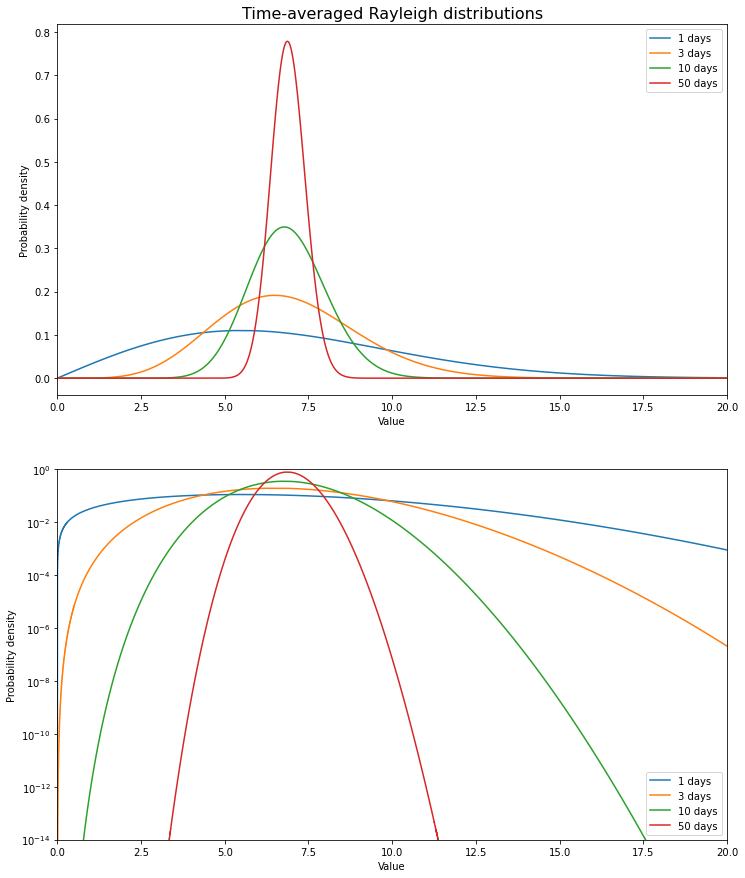

In [103]:
xmax = 30
divs0 = 10000
x0 = np.linspace(0, xmax, divs0)
pdf0 = stats.rayleigh.pdf(x0, scale=5.5)
delta0 = xmax / divs0
pmf0 = pdf0 * delta0

xs = []
pdfs = []

ns = [1,3,10,50]
for n in ns:
    pmf = pmf0
    for _ in range(0,n-1):
        pmf = signal.convolve(pmf, pmf0)
    divs = pmf.size
    delta = xmax / divs
    xs.append(np.linspace(0, xmax, divs))
    pdfs.append(pmf / delta)
    
fig, axs = plt.subplots(2,1, figsize=(12, 15))
axs[1].set_yscale('log')
axs[1].set_ylim([10e-15,1])
for ax in axs:
    for n, x, pdf in zip(ns, xs, pdfs):
        ax.step(x, pdf, label=f"{n} days")
    ax.set_xlim([0,20])
    ax.set_xlabel("Value")
    ax.set_ylabel("Probability density")
    ax.legend()
    
axs[0].set_title("Time-averaged Rayleigh distributions", fontsize=16);

Averaging over more days, the distribution becomes narrower and more symmetric, clearly approaching a Gaussian (as mandated by the central limit theorem). However, below we plot the 100 day average against a Gaussian with the same mean and variance and see that even with this long observing interval they still differ noticeably. It would thus presumably take several hundred days of observations, possibly as many as a thousand, before we could confidently assume that the background is Gaussian.

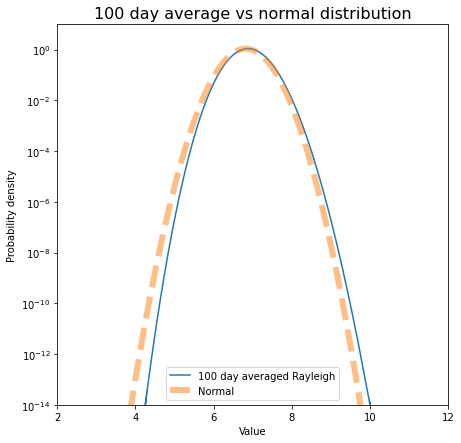

In [117]:
pmf = pmf0
for _ in range(0,99):
    pmf = signal.convolve(pmf, pmf0)
divs = pmf.size
delta = xmax / divs
x = np.linspace(0, xmax, divs)
pdf = pmf / delta

mean = np.sum(x * pmf)
std = np.sqrt(np.sum((x - mean)**2 * pmf))

fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.set_yscale('log')
ax.plot(x, pdf, label="100 day averaged Rayleigh")
ax.plot(x0, stats.norm.pdf(x0, loc=mean, scale=std), linewidth=6, alpha=0.5, linestyle='dashed', label="Normal")
ax.set_xlim([2,12])
ax.set_ylim([10e-15,10])
ax.set_title("100 day average vs normal distribution", fontsize=16)
ax.set_xlabel("Value")
ax.set_ylabel("Probability density")
ax.legend();

## Problem 3

We assume that the thermal noise has a width of 0.5 and the signal has a strength of 4.

### (A)

This significance of this observation, assuming we know the exact pixel to observe, is 8 sigma, more than enough to declare a detection.

In [119]:
prob = stats.norm.sf(4, scale=0.5)
sigma = stats.norm.isf(prob)
print(f"{prob:.3} \t {sigma:.3} sigma")

6.22e-16 	 8.0 sigma


### (B)

We are interested in the brightest value among the 10,000 pixels in our observing region. In general, calculating the distribution of the maximum of a collection of random variables is very difficult. However, when the probability is low, i.e. in the tails of the distribution, the pdf of the maximum is well approximated by the original pdf times the number of pixels. In this case, that is 10,000 times a normal distribution with width 0.5.

### (C)

With the same signal strength as before (4) but looking over the larger region, the significance only drops to 6.8 sigma, still enough for a detection.

(Note that we have pulled the factor of 10000 out of the integral in the calculation below so we can still use the builtin survival function.)

In [125]:
prob = 10000 * stats.norm.sf(4, scale=0.5)
sigma = stats.norm.isf(prob)
print(f"{prob:.3} \t {sigma:.3} sigma")

6.22e-12 	 6.77 sigma


## Problem 4

### (A)

The detection threshold for a single pixel is 2.5.

In [131]:
prob = stats.norm.sf(5)
print(stats.norm.isf(prob, scale=0.5))

2.5000000000000004


### (B)

For a signal to give a probability of $P$ in the 10,000 pixel distribution, it must give a probability of $P/10000$ in the single pixel distribution, so we can calculate the signal threshold for the 10,000 pixel distribution as below, finding it to be 3.3.

In [130]:
print(stats.norm.isf(prob/10000, scale=0.5))

3.275268806352667


### (C)

This difference between the detection thresholds for one pixel and 10,000 pixels is quite small. This is because the background is Gaussian distributed, which means it falls off very rapidly at the tails. This means that even a moderately brighter signal is _drastically_ less likely to be due to noise, so even when the _probability_ threshold is raised by a factor of 10,000, the _signal_ threshold is increased only slightly.

### (D)

Even looking in a 10 million pixel region, the signal threshold for a 5 sigma is only raised to 3.9, still not even twice the original threshold.

In [132]:
print(stats.norm.isf(prob/10e7, scale=0.5))

3.904843351809582


### (E)

As explained in (C), the relative insensitivity of this hypothetical experiment to the look elsewhere effect is a consequence of the rapid fall-off the Gaussian background's tails. If the background followed a distribution with a slower-tapering tail, the loss in sensitivity would be greater.